In [1]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"rizkyely","key":"a76d26afe6e59d40455c73999d68f31c"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [2]:
! kaggle datasets download linjustin/train-val-test-tcga-coad-msi-mss

100% 5.47G/5.48G [02:59<00:00, 84.9MB/s]
100% 5.48G/5.48G [02:59<00:00, 32.8MB/s]


In [3]:
import os
import zipfile

local_zip = '/content/train-val-test-tcga-coad-msi-mss.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [4]:
# Mendefenisikan data untuk test dan train
base_dir = '/content/tcga_coad_msi_mss'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

train_msimut_dir = os.path.join(train_dir, 'MSIMUT')
train_mss_dir = os.path.join(train_dir, 'MSS')

val_msimut_dir = os.path.join(val_dir, 'MSIMUT')
val_mss_dir = os.path.join(val_dir, 'MSS')

In [5]:
print('Train MSIMUT :', os.listdir(train_msimut_dir)[:2])
print('Train MSS :', os.listdir(train_mss_dir)[:2])

print('Val MSIMUT :', os.listdir(val_msimut_dir)[:2])
print('Val MSS :', os.listdir(val_mss_dir)[:2])


Train MSIMUT : ['blk-WVRGFICKWCLH-TCGA-CM-4743-01Z-00-DX1.jpg', 'blk-TNISDQQVAAWS-TCGA-G4-6302-01Z-00-DX1.jpg']
Train MSS : ['blk-SVEYEFRTIYIT-TCGA-DM-A1D9-01Z-00-DX1.jpg', 'blk-TWCGNLFIYAKN-TCGA-AA-A01Z-01Z-00-DX1.jpg']
Val MSIMUT : ['blk-IIQECYFYSRML-TCGA-CM-6674-01Z-00-DX1.jpg', 'blk-FNDNKAIRVIWA-TCGA-CM-6171-01Z-00-DX1.jpg']
Val MSS : ['blk-TNIEVERLAFTQ-TCGA-CM-5344-01Z-00-DX1.jpg', 'blk-SDVHCKCWRTLF-TCGA-AF-4110-01Z-00-DX1.jpg']


In [6]:
print(len(os.listdir(train_msimut_dir)))
print(len(os.listdir(train_mss_dir)))
print(len(os.listdir(val_msimut_dir)))
print(len(os.listdir(val_mss_dir)))

60031
93818
7503
11727


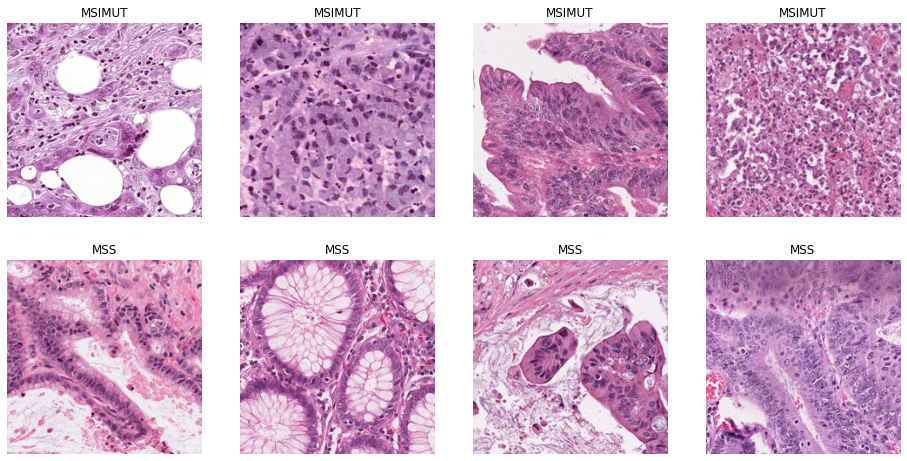

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


nrows = 2
ncols = 4

pic_index = 0

fig = plt.gcf()
fig.set_size_inches( ncols * 4,nrows * 4)

pic_index += 8
msimut_img = [os.path.join(train_msimut_dir, fname) 
                for fname in os.listdir(train_msimut_dir)[pic_index-4:pic_index]]
mss_img  = [os.path.join(train_mss_dir, fname) 
                for fname in os.listdir(train_mss_dir)[pic_index-4:pic_index]]

for i, img_path in enumerate(msimut_img+mss_img):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.title(img_path.split(os.path.sep)[-2])

plt.show()

# 2. Preprocessing Data

In [8]:
# Tulis Kode Anda Disini
import cv2
import numpy as np

# Gather data test
train_data = []
train_label = []
for r, d, f in os.walk(train_dir):
    for file in f:
        if ".jpg" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (50,50))
            train_data.append(image)
            label = imagePath.split(os.path.sep)[-2]
            train_label.append(label)
            
train_data = np.array(train_data)
train_label = np.array(train_label)

In [9]:
# Tulis Kode Anda Disini
import cv2
import numpy as np

# Gather data test
val_data = []
val_label = []
for r, d, f in os.walk(val_dir):
    for file in f:
        if ".jpg" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (50,50))
            val_data.append(image)
            label = imagePath.split(os.path.sep)[-2]
            val_label.append(label)
            
val_data = np.array(val_data)
val_label = np.array(val_label)

In [10]:
print("Train Data = ", train_data.shape)
print("Train Label = ", train_label.shape)
print("Validation Data = ", val_data.shape)
print("Validation Label = ", val_label.shape)

Train Data =  (153849, 50, 50, 3)
Train Label =  (153849,)
Validation Data =  (19230, 50, 50, 3)
Validation Label =  (19230,)


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,shear_range=0.2,zoom_range=0.2, horizontal_flip= True)
training_set = train_datagen.flow_from_directory('/content/tcga_coad_msi_mss/train',target_size=(50, 50),batch_size= 32,class_mode="binary")
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('/content/tcga_coad_msi_mss/test',target_size= (50,50), batch_size = 32, class_mode = 'binary')

Found 153849 images belonging to 2 classes.
Found 19233 images belonging to 2 classes.


In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Conv2D, Flatten, Dropout,
                                     MaxPooling2D, Activation, BatchNormalization)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

model = Sequential([
    # Conv layer 1/Input layer
    Conv2D(64, kernel_size = (5, 5),padding = 'same', activation = 'relu', 
           input_shape = (50, 50, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2, 2)),
    Dropout(0.25),
    
    # Conv layer 2
    Conv2D(64, kernel_size = (5, 5), padding = 'same', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2, 2)),
    Dropout(0.25),

    # Conv layer 3
    Conv2D(128, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2, 2), strides = (2, 2)),
    Dropout(0.25),
    
    # Conv layer 4
    Conv2D(128, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2, 2), strides = (2, 2)),
    Dropout(0.25),

    # Fully connected layer 1
    Flatten(),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.25),
    
    # Fully connected last layer
    Dense(1, activation = 'sigmoid')
])

# Standard metrics for binary classification 
metrics = [
    tf.keras.metrics.TruePositives(name = 'tp'),
    tf.keras.metrics.FalsePositives(name = 'fp'),
    tf.keras.metrics.TrueNegatives(name = 'tn'),
    tf.keras.metrics.BinaryAccuracy(name = 'accuracy'),
    tf.keras.metrics.Precision(name = 'precision'),
    tf.keras.metrics.Recall(name = 'recall'),
    tf.keras.metrics.AUC(name = 'auc')
]

initial_lr = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_lr,
    decay_steps = 100000,
    decay_rate = 0.96,
    staircase = True
)

model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = lr_schedule,
                                                  momentum = 0.9,
                                                  nesterov = True),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = metrics)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 64)        4864      
                                                                 
 batch_normalization (BatchN  (None, 50, 50, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 25, 25, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        102464    
                                                                 
 batch_normalization_1 (Batc  (None, 25, 25, 64)       2

In [13]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.80):
      print("\n\n Akurasi train dan validasi didapat telah mencapai nilai > 80%!")
      self.model.stop_training = True
callbacks = myCallback()

In [14]:

history = model.fit(training_set,
                    epochs = 3,
                    validation_data = test_set,
                    callbacks = callbacks)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


4808/4808 [==============================] - 2995s 622ms/step - loss: 0.6871 - tp: 91156.0000 - fp: 58278.0000 - tn: 1753.0000 - accuracy: 0.6039 - precision: 0.6100 - recall: 0.9716 - auc: 0.5062 - val_loss: 0.6672 - val_tp: 11728.0000 - val_fp: 7505.0000 - val_tn: 0.0000e+00 - val_accuracy: 0.6098 - val_precision: 0.6098 - val_recall: 1.0000 - val_auc: 0.5188
Epoch 2/3
4808/4808 [==============================] - 3014s 627ms/step - loss: 0.6696 - tp: 93472.0000 - fp: 59759.0000 - tn: 272.0000 - accuracy: 0.6093 - precision: 0.6100 - recall: 0.9963 - auc: 0.5163 - val_loss: 0.6660 - val_tp: 11728.0000 - val_fp: 7505.0000 - val_tn: 0.0000e+00 - val_accuracy: 0.6098 - val_precision: 0.6098 - val_recall: 1.0000 - val_auc: 0.5276
Epoch 3/3
4808/4808 [==============================] - 3082s 641ms/step - loss: 0.6662 - tp: 90693.0000 - fp: 56654.0000 - tn: 3377.0000 - accuracy: 0.6114 - precision: 0.6155 - recall: 0.9667 - auc: 0.5434 - val_loss: 0.6682 - val_tp: 11728.0000 - val_fp: 7505.0

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Conv2D, Flatten, Dropout,
                                     MaxPooling2D, Activation, BatchNormalization)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

model2 = Sequential([
    # Conv layer 1/Input layer
    Conv2D(64, kernel_size = (5, 5),padding = 'same', activation = 'relu', 
           input_shape = (50, 50, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2, 2)),
    Dropout(0.25),
    

    # Conv layer 2
    Conv2D(128, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2, 2), strides = (2, 2)),
    Dropout(0.25),
    
    # Conv layer 3
    Conv2D(128, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2, 2), strides = (2, 2)),
    Dropout(0.25),

    # Fully connected layer 1
    Flatten(),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.25),
    
    # Fully connected last layer
    Dense(1, activation = 'sigmoid')
])

# Standard metrics for binary classification 
metrics = [
    tf.keras.metrics.TruePositives(name = 'tp'),
    tf.keras.metrics.FalsePositives(name = 'fp'),
    tf.keras.metrics.TrueNegatives(name = 'tn'),
    tf.keras.metrics.BinaryAccuracy(name = 'accuracy'),
    tf.keras.metrics.Precision(name = 'precision'),
    tf.keras.metrics.Recall(name = 'recall'),
    tf.keras.metrics.AUC(name = 'auc')
]

initial_lr = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_lr,
    decay_steps = 100000,
    decay_rate = 0.96,
    staircase = True
)

model2.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = lr_schedule,
                                                  momentum = 0.9,
                                                  nesterov = True),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = metrics)

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 50, 50, 64)        4864      
                                                                 
 batch_normalization_5 (Batc  (None, 50, 50, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 25, 25, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 25, 128)       73856     
                                                                 
 batch_normalization_6 (Batc  (None, 25, 25, 128)     

In [16]:
history2 = model2.fit(training_set,
                    epochs = 3,
                    validation_data = test_set,
                    callbacks = callbacks)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


4808/4808 [==============================] - 2733s 568ms/step - loss: 0.6841 - tp: 86801.0000 - fp: 53025.0000 - tn: 7006.0000 - accuracy: 0.6097 - precision: 0.6208 - recall: 0.9252 - auc: 0.5450 - val_loss: 0.6584 - val_tp: 11129.0000 - val_fp: 6612.0000 - val_tn: 893.0000 - val_accuracy: 0.6251 - val_precision: 0.6273 - val_recall: 0.9489 - val_auc: 0.5708
Epoch 2/3
4808/4808 [==============================] - 2689s 559ms/step - loss: 0.6589 - tp: 87133.0000 - fp: 51005.0000 - tn: 9026.0000 - accuracy: 0.6250 - precision: 0.6308 - recall: 0.9287 - auc: 0.5709 - val_loss: 0.7050 - val_tp: 7402.0000 - val_fp: 4067.0000 - val_tn: 3438.0000 - val_accuracy: 0.5636 - val_precision: 0.6454 - val_recall: 0.6311 - val_auc: 0.5576
Epoch 3/3
4808/4808 [==============================] - 2676s 557ms/step - loss: 0.6522 - tp: 86059.0000 - fp: 48127.0000 - tn: 11904.0000 - accuracy: 0.6367 - precision: 0.6413 - recall: 0.9173 - auc: 0.5905 - val_loss: 0.6504 - val_tp: 11354.0000 - val_fp: 6660.000

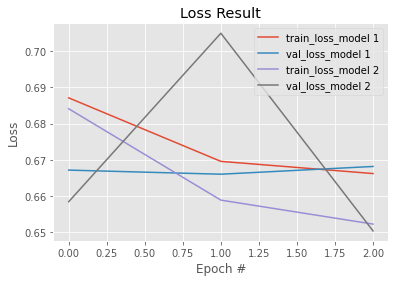

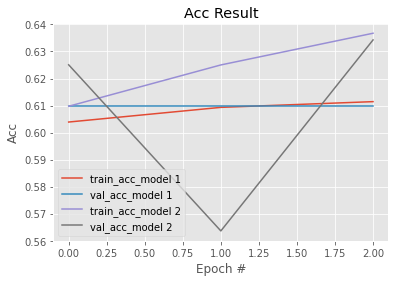

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 3), history.history["loss"], label="train_loss_model 1")
plt.plot(np.arange(0, 3), history.history["val_loss"], label="val_loss_model 1")
plt.plot(np.arange(0, 3), history2.history["loss"], label="train_loss_model 2")
plt.plot(np.arange(0, 3), history2.history["val_loss"], label="val_loss_model 2")
plt.title("Loss Result")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 3), history.history["accuracy"], label="train_acc_model 1")
plt.plot(np.arange(0, 3), history.history["val_accuracy"], label="val_acc_model 1")
plt.plot(np.arange(0, 3), history2.history["accuracy"], label="train_acc_model 2")
plt.plot(np.arange(0, 3), history2.history["val_accuracy"], label="val_acc_model 2")
plt.title("Acc Result")
plt.xlabel("Epoch #")
plt.ylabel("Acc")
plt.legend()
plt.show()